In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import log_loss
from sklearn.metrics import brier_score_loss
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt


In [12]:
# Import the required libraries
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Read the CSV file
data = pd.read_csv('costsensitiveregression.csv')

# Separate the independent variables (X) and the dependent variable (y)
X = data.iloc[:, :11]
y = data.iloc[:, 11:13]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# # Standardize the data
# scaler = StandardScaler()
# X_train = scaler.fit_transform(X_train)
# X_test = scaler.transform(X_test)

# Convert to PyTorch tensors
X_train = torch.tensor(X_train.values, dtype=torch.float32)
X_test = torch.tensor(X_test.values, dtype=torch.float32)
y_train = torch.tensor(y_train.to_numpy(), dtype=torch.float32)
y_test = torch.tensor(y_test.to_numpy(), dtype=torch.float32)

# Create a custom dataset
class CSLogRegDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Create DataLoader objects for training and testing
train_dataset = CSLogRegDataset(X_train, y_train)
test_dataset = CSLogRegDataset(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [13]:
class CostSensitiveLogisticRegression(nn.Module):
    def __init__(self, input_dim):
        super(CostSensitiveLogisticRegression, self).__init__()
        self.linear = nn.Linear(input_dim, 1)

    def forward(self, x):
        return torch.sigmoid(self.linear(x))

    def compute_loss(self, y_pred, y_true, false_negative_cost):
        epsilon = 1e-7
        true_positive_cost = 4
        false_positive_cost = 4
        true_negative_cost = 0

        # Compute the losses for true positives, false positives, true negatives, and false negatives
        tp_loss = y_true * torch.log(y_pred + epsilon) * true_positive_cost
        fp_loss = y_true * torch.log(1 - y_pred + epsilon) * false_positive_cost
        tn_loss = (1 - y_true) * torch.log(1 - y_pred + epsilon) * true_negative_cost
        fn_loss = (1 - y_true) * torch.log(y_pred + epsilon) * false_negative_cost

        # Compute the total loss
        total_loss = -(tp_loss + fp_loss + tn_loss + fn_loss).mean()

        return total_loss


In [14]:
def evaluate_model(model, data_loader):
    model.eval()
    correct = 0
    total = 0
    total_loss = 0

    with torch.no_grad():
        for data, target in data_loader:
            # Forward pass
            output = model(data)

            # Calculate the false_negative_cost from the target data
            false_negative_cost = target[:, 1]
            target = target[:, 0].view(-1, 1)

            # Compute the loss
            loss = model.compute_loss(output, target, false_negative_cost)

            # Update the total loss
            total_loss += loss.item()

            # Calculate the number of correct predictions
            predicted = (output > 0.5).float()
            correct += (predicted == target).sum().item()
            total += target.size(0)

    # Calculate accuracy and average loss
    accuracy = correct / total
    average_loss = total_loss / len(data_loader)

    return accuracy, average_loss

# # Evaluate the model on the training set
# train_accuracy, train_loss = evaluate_model(model, train_loader)
# print(f'Training accuracy: {train_accuracy * 100:.2f}%, Training loss: {train_loss:.4f}')

# # Evaluate the model on the testing set
# test_accuracy, test_loss = evaluate_model(model, test_loader)
# print(f'Testing accuracy: {test_accuracy * 100:.2f}%, Testing loss: {test_loss:.4f}')


Epoch 1/100, Training Loss: 10.9454, Validation Loss: 5.5730
Epoch 2/100, Training Loss: 5.8854, Validation Loss: 5.5719
Epoch 3/100, Training Loss: 5.7957, Validation Loss: 5.6082
Epoch 4/100, Training Loss: 5.7512, Validation Loss: 5.7117
Epoch 5/100, Training Loss: 5.9997, Validation Loss: 5.5432
Epoch 6/100, Training Loss: 5.6598, Validation Loss: 5.5386
Epoch 7/100, Training Loss: 5.7396, Validation Loss: 5.5499
Epoch 8/100, Training Loss: 5.8811, Validation Loss: 5.6654
Epoch 9/100, Training Loss: 5.8248, Validation Loss: 5.5876
Epoch 10/100, Training Loss: 5.8927, Validation Loss: 5.8075
Epoch 11/100, Training Loss: 5.8199, Validation Loss: 5.8830
Epoch 12/100, Training Loss: 5.7050, Validation Loss: 5.5974
Epoch 13/100, Training Loss: 5.7874, Validation Loss: 6.2051
Epoch 14/100, Training Loss: 5.7161, Validation Loss: 6.3535
Epoch 15/100, Training Loss: 5.9420, Validation Loss: 6.3227
Epoch 16/100, Training Loss: 5.9910, Validation Loss: 5.6956
Epoch 17/100, Training Loss: 5.7

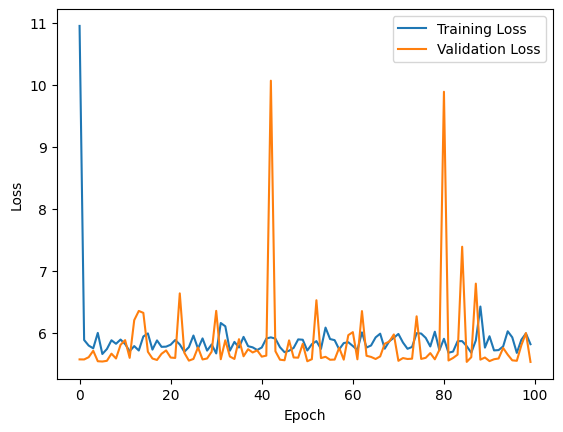

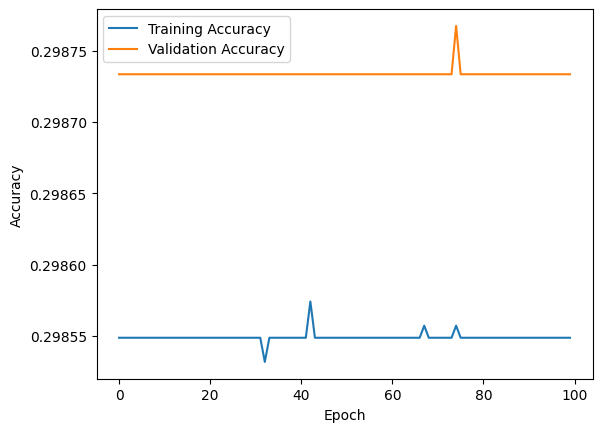

In [16]:
# Initialize the model, optimizer, and number of epochs
model = CostSensitiveLogisticRegression(input_dim=X_train.shape[1])
optimizer = optim.Adam(model.parameters(), lr=0.01)
num_epochs = 100

# Training loop
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

for epoch in range(num_epochs):
    epoch_loss = 0.0

    for batch_idx, (data, target) in enumerate(train_loader):
        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        output = model(data)

        # Calculate the false_negative_cost from the target data
        false_negative_cost = target[:, 1]
        target = target[:, 0].view(-1, 1)

        # Compute the loss
        loss = model.compute_loss(output, target, false_negative_cost)

        # Backward pass
        loss.backward()

        # Optimize
        optimizer.step()

        # Update the epoch loss
        epoch_loss += loss.item()

    # Store the average loss for this epoch
    train_losses.append(epoch_loss / len(train_loader))

    # Evaluate the model on the training set
    train_accuracy, _ = evaluate_model(model, train_loader)
    train_accuracies.append(train_accuracy)

    # Evaluate the model on the validation set
    val_accuracy, val_loss = evaluate_model(model, test_loader)
    val_accuracies.append(val_accuracy)
    val_losses.append(val_loss)

    # Print the results for this epoch
    print(f'Epoch {epoch + 1}/{num_epochs}, Training Loss: {train_losses[-1]:.4f}, Validation Loss: {val_losses[-1]:.4f}')

# Plot the training and validation loss over time
plt.figure()
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot the training and validation accuracy over time
plt.figure()
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


Epoch: 1 TrainLoss: 143.742    ValLoss: 131.527    TrainAccuracy: 30.141    ValAccuracy: 30.027
Epoch: 2 TrainLoss: 106.689    ValLoss: 80.842    TrainAccuracy: 64.459    ValAccuracy: 84.733
Epoch: 3 TrainLoss: 79.632    ValLoss: 69.546    TrainAccuracy: 85.401    ValAccuracy: 86.153
Epoch: 4 TrainLoss: 73.646    ValLoss: 65.897    TrainAccuracy: 86.174    ValAccuracy: 86.347
Epoch: 5 TrainLoss: 71.032    ValLoss: 63.953    TrainAccuracy: 86.284    ValAccuracy: 86.287
Epoch: 6 TrainLoss: 69.436    ValLoss: 62.689    TrainAccuracy: 86.305    ValAccuracy: 86.273
Epoch: 7 TrainLoss: 68.358    ValLoss: 61.824    TrainAccuracy: 86.291    ValAccuracy: 86.293
Epoch: 8 TrainLoss: 67.395    ValLoss: 61.089    TrainAccuracy: 86.335    ValAccuracy: 86.340
Epoch: 9 TrainLoss: 66.693    ValLoss: 60.465    TrainAccuracy: 86.332    ValAccuracy: 86.327
Epoch: 10 TrainLoss: 66.071    ValLoss: 59.973    TrainAccuracy: 86.359    ValAccuracy: 86.340
Epoch: 11 TrainLoss: 65.553    ValLoss: 59.588    TrainA

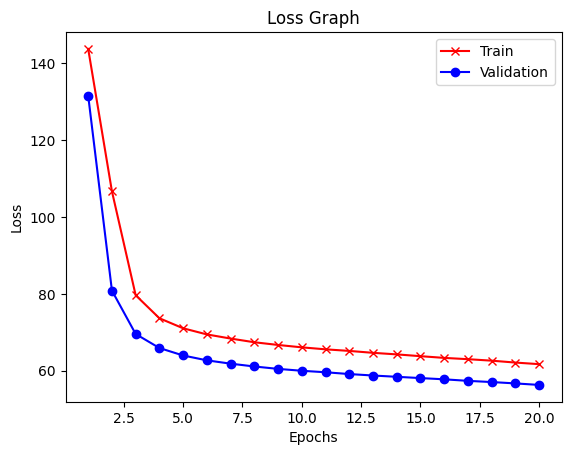

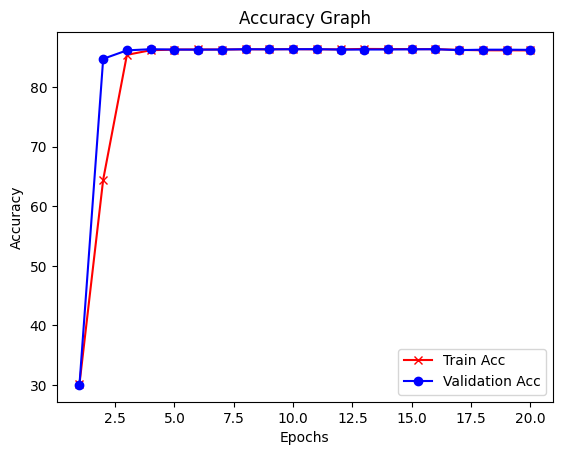


Test accuracy 86.530, Precision 0.782, Recall 0.754, F1 0.768


In [2]:
"""
To run: python3 costSensitiveLogistic.py
"""

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset, random_split

torch.manual_seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(0)

# Global variables
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
PATH = "./data.csv"
fpc, tpc, tnc = 150.0, 150.0, 0.0
fnc = None
cols = None

__AUTHORS__ = [
    ("Vinta Reethu", "ES18BTECH11028"),
    ("Akash Tadwai", "ES18BTECH11019"),
    ("Chaitanya Janakie", "CS18BTECH11036"),
]


class Net(nn.Module):
    def __init__(self, in_dim, out_dim):
        super(Net, self).__init__()
        self.linear = nn.Sequential(nn.Linear(in_dim, out_dim), nn.Sigmoid())

    def forward(self, x):
        return self.linear(x)


def preProcesData():
    """Loads data and divides it into train and test sets."""
    global fnc, cols
    df = pd.read_csv(PATH)
    # defining all costs
    fnc = df.iloc[:, -1]  # last column is false negative costs

    # convert data to Pytorch Tensors
    df = df.drop(["FNC"], axis=1)  # drop the last column (FNC)
    data, targets = df.iloc[:, 1:], df.iloc[:, 0]
    cols = df.columns.shape[0] - 1  # X shape
    data, targets, fnc = (
        torch.FloatTensor(data.to_numpy()),
        torch.LongTensor(targets.to_numpy()),
        torch.FloatTensor(fnc.to_numpy()),
    )

    # Split into train, validation and test data
    dataset = TensorDataset(data, targets, fnc)
    trainset, valset, testset = random_split(dataset, [100000, 15000, 32636])
    trainloader = DataLoader(trainset, batch_size=1024, shuffle=True)
    valloader = DataLoader(valset, batch_size=1024, shuffle=False)
    testloader = DataLoader(testset, batch_size=1024, shuffle=False)

    # return trainloader, valloader, testloader
    return trainloader, valloader, testloader


def train(model, device, train_loader, optimizer, epoch):
    """Trains the model for one epoch"""
    model.train()
    correct, total = 0, 0
    loss_epoch = []  # to plot loss
    for _, (data, target, cfn) in enumerate(train_loader):
        # send the image, target to the device
        data, target, cfn = data.to(device), target.to(device), cfn.to(device)
        # flush out the gradients stored in optimizer
        optimizer.zero_grad()
        # pass the image to the model and assign the output to variable named output
        hx = model(data).squeeze(1)
        # calculate the loss using the output and the target
        pred = (hx > 0.5).long()
        correct += (pred == target).sum().item()
        total += hx.size(0)

        loss = target * (hx * tpc + (1 - hx) * cfn) + (1 - target) * (
            hx * fpc + (1 - hx) * tnc
        )  # calculate cost sensitive Loss
        loss = loss.mean()

        loss.backward()  # calculate gradients of all parameters with respect to the loss
        loss_epoch.append(loss.data.item())
        optimizer.step()

    return np.mean(loss_epoch), 100.0 * correct / total, model


def validation(model, device, val_loader):
    model.eval()
    correct, total = 0, 0
    losses = []
    with torch.no_grad():
        for data, target, cfn in val_loader:
            data, target, cfn = data.to(device), target.to(device), cfn.to(device)
            hx = model(data).squeeze(1)
            pred = (hx > 0.5).long()
            correct += (pred == target).sum().item()
            total += hx.size(0)
            loss = target * (hx * tpc + (1 - hx) * cfn) + (1 - target) * (
                hx * fpc + (1 - hx) * tnc
            )
            losses.append(loss.mean().item())

    return np.mean(losses), 100.0 * correct / total, model


def test(model, device, test_loader):
    model.eval()
    model.load_state_dict(torch.load("./best.pth"))
    correct, total = 0, 0
    tp, fp, fn = 0, 0, 0
    for (x, y, cfn) in test_loader:  # evaluate on test data
        x, y, cfn = x.to(device), y.to(device), cfn.to(device)
        hx = model(x).squeeze(1)
        # for accuracy, find correct predictions
        pred = (hx > 0.5).long()
        correct += (pred == y).sum().item()
        total += hx.size(0)

        # find true positives, false positives, false negatives
        tp += ((pred == 1) * (y == 1)).sum().item()
        fp += ((pred == 1) * (y == 0)).sum().item()
        fn += ((pred == 0) * (y == 1)).sum().item()

    # Find accuracy, precision, recall, F1 Score
    prec, rec = 1.0 * tp / (tp + fp), 1.0 * tp / (tp + fn)
    f1 = 2 * prec * rec / (prec + rec)

    print(
        "\nTest accuracy {:.3f}, Precision {:.3f}, Recall {:.3f}, F1 {:.3f}".format(
            100.0 * correct / total, prec, rec, f1
        )
    )


def plotting(
    epochs, train_loss_values, train_acc_values, test_loss_values, test_acc_values
) -> None:
    plt.plot(epochs, train_loss_values, "r-", label="Train", marker="x")
    plt.plot(epochs, test_loss_values, "b-", label="Validation", marker="o")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Loss Graph")
    plt.legend()
    plt.savefig("./Loss.png")
    plt.show()
    print("")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title("Accuracy Graph")
    plt.plot(epochs, train_acc_values, "r-", label="Train Acc", marker="x")
    plt.plot(epochs, test_acc_values, "b-", label="Validation Acc", marker="o")
    plt.legend()
    plt.savefig("./Accuracy.png")
    plt.show()


if __name__ == "__main__":

    trainloader, valloader, testloader = preProcesData()

    model = Net(cols, 1).to(device)
    optimizer = torch.optim.Adam(model.parameters())

    train_loss_values = []
    train_acc_values = []
    val_loss_values = []
    val_acc_values = []
    EPOCHS = 20  # number of epochs
    best_acc = 0.0

    for epoch in range(1, EPOCHS + 1):
        train_loss, train_acc, model = train(
            model, device, trainloader, optimizer, epoch
        )
        val_loss, val_acc, model = validation(model, device, valloader)
        train_loss_values.append(train_loss)
        train_acc_values.append(train_acc)
        val_loss_values.append(val_loss)
        val_acc_values.append(val_acc)

        if val_acc_values[-1] > best_acc:  # if val acc is better, save checkpoint
            torch.save(model.state_dict(), "./best.pth")
            best_acc = val_acc_values[-1]
        print(
            f"Epoch: {epoch} TrainLoss: {train_loss_values[-1]:.3f}    ValLoss: {val_loss_values[-1]:.3f}    TrainAccuracy: {train_acc_values[-1]:.3f}    ValAccuracy: {val_acc_values[-1]:.3f}"
        )

    plotting(
        np.linspace(1, EPOCHS, EPOCHS).astype(int),
        train_loss_values,
        train_acc_values,
        val_loss_values,
        val_acc_values,
    )
    test(model, device, testloader)